# **Youtube Analysis Project**

In this project, I want to analyze the content of Indonesian Youtuber [Ferry Irwandi ](https://www.youtube.com/@ferryirwandi). <br>

---

**Author:** Satria Audria Sakti

**Connect with me:**  
- LinkedIn: 🔗 [satriaaudrias](https://www.linkedin.com/in/satriaaudrias)  
- GitHub: 🐙 [satria4s](https://github.com/satria4s)

---

In [2]:
# Import the Youtube API Key

from google.colab import userdata
YT_API = userdata.get('YT_DATA_KEY')

Once done, continue the project

In [3]:
# ----------------------------------------------------------------------------------- #
# Let's start it by loading the pre-requisites library (either it will be used or not)
# ----------------------------------------------------------------------------------- #

# OpenML Library
!pip install openml
import openml

# Data handler toolkit
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libs
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Others
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

imported_libraries = [
    openml,
    tf,
    np,
    pd,
    sns
]

for lib in imported_libraries:
    try:
        print(f"{lib.__name__}: {lib.__version__}")
    except AttributeError:
        print(f"{lib.__name__}: Version not found / Library not installed")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.3/94.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.5 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=5ab217a92966324a716df677d01b9c00d4dbe2cb6bbfffb511b3f103cd439a58
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


openml: 0.15.0
tensorflow: 2.17.1
numpy: 1.26.4
pandas: 2.2.2
seaborn: 0.13.2


Now generate the API that previously created.

In [4]:
# Load the API
import googleapiclient.discovery

# Replace with your actual API key
api_key = YT_API

# Initialize the YouTube API client
youtube = googleapiclient.discovery.build('youtube', 'v3', developerKey=api_key)


In [5]:
# First, let's fetch the channel ID and brief information about it

def get_channel_info(channel_id):
    request = youtube.channels().list(
        part="snippet,statistics",  # 'snippet' for basic info, 'statistics' for views, subscribers, etc.
        id=channel_id               # Channel ID here
    )
    response = request.execute()

    # Extracting useful channel details
    channel_info = response['items'][0]
    snippet = channel_info['snippet']
    statistics = channel_info['statistics']

    return {
        'channel_name': snippet['title'],
        'description': snippet['description'],
        'published_at': snippet['publishedAt'],
        'subscriber_count': statistics.get('subscriberCount', 'Not Available'),
        'view_count': statistics.get('viewCount', 'Not Available'),
        'video_count': statistics.get('videoCount', 'Not Available')
    }

channel_id = "UCC_OYI6VZtuEZuq49Ht-cQQ"
channel_data = get_channel_info(channel_id)
cd_df = pd.DataFrame([channel_data])
cd_df.head()


,channel_name,description,published_at,subscriber_count,view_count,video_count
0,Ferry Irwandi,Find me on Instagram : @irwandiferry,2010-04-07T10:39:22Z,1300000,106010465,281


In [6]:
# Then fetch the video playlist available
def get_uploads_playlist_id(channel_id):
    request = youtube.channels().list(
        part='contentDetails',
        id=channel_id  # This should be the YouTube channel ID
    )
    response = request.execute()

    # Access the uploads playlist ID
    uploads_playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
    return uploads_playlist_id

channel_id = channel_id
uploads_playlist_id = get_uploads_playlist_id(channel_id)
print(uploads_playlist_id)


# Fetch the video IDs
def get_video_ids(playlist_id):
    video_ids = []
    next_page_token = None

    while True:
        request = youtube.playlistItems().list(
            part='snippet',
            playlistId=playlist_id,
            maxResults=50,  # Maximum allowed per page
            pageToken=next_page_token
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['snippet']['resourceId']['videoId'])

        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    return video_ids

video_ids = get_video_ids(uploads_playlist_id)
print(video_ids)

# Fetch Video Details and Sort by Count

def get_video_details(video_ids):
    video_details = []
    for i in range(0, len(video_ids), 50):  # YouTube API allows up to 50 IDs per request
        request = youtube.videos().list(
            part='snippet,statistics',
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for item in response['items']:
            video_details.append({
                'title': item['snippet']['title'],
                'video_id': item['id'],
                'view_count': int(item['statistics']['viewCount']),
                'like_count': int(item['statistics'].get('likeCount', 0)),
                'comment_count': int(item['statistics'].get('commentCount', 0))
            })
    return video_details

# Fetch details and sort by view count
video_details = get_video_details(video_ids)
sorted_videos = sorted(video_details, key=lambda x: x['view_count'], reverse=True)

# Display top videos
for video in sorted_videos[:10]:  # Show top 10 videos
    print(video)

# Save the video details data, and make a dataframe for it
df_videos = pd.DataFrame(sorted_videos)
df_videos.head(10)



UUC_OYI6VZtuEZuq49Ht-cQQ
['zc9n_dvzMuo', 'gdPI9gDq_qg', 'NgJYxsrR5GA', 'WuU6tDdSPFY', 'gWVKBso3zjM', 'UpqxSiJ4ha0', '5TgqVpWmlaI', '9XmYUUNcwAw', 'pQPxnDcmWDk', 'XtZdVq-_UwI', 'iDJfBwT_40s', 'zFjx1xykQm4', '1qDL8bPuj_I', 'ur4Nzzsj4G0', 'AU5rSQutp1k', 'YivmeY451nk', '8cPwG-0D93I', 'GC2EF_DR78g', 'VrevFR9yj4Y', 'GUK0urJHmbo', '9Phn6-mb3w8', 'Y-IiFPxCO5w', 'gvI7iGa5UVU', 'abopQwoPkCk', 'jmWaHd_PnTo', 'jdCLLPmRdG0', 'eENYaG3e8R8', 'UvEwBPZS8EA', 'TGHJhK-NeJI', 'dfZrsAbJcHk', 'pEoqWcJDBME', 'c0JLJqbxHzQ', 'Opkp97WkSWk', 'iag6byIwQoM', 'KImr5ForJbo', 'uu7h22wlkPM', 'MPh7HymZufQ', 'E9cEu94G4fw', 'T74tp2r5_qU', 'DF5MQa9QRIE', '6vWRfGHqJ3s', 'lSmZWxrwhAs', '3MRnWUh3raI', 'B2fQXz27kTk', 'iPSIDG02Qko', 'hRMCIai8nRQ', 'Kxy2g7JdTk8', 'ixYM0eTMQlw', 'FwA_X4qAPaQ', 'PHyyKLzc2Ys', 'Np1vp318qYw', 'ebbj4GDm1wU', 'YhO-3QMNkwU', 'CUlFnZBKgi4', '-v1Ltqlsl9k', 'p9Zm1zbsfWo', 'Wl5N91OAoAY', 'ngJwnEwbCgE', 'e9I13dU8L-Y', 'WpUniZKzZuo', 'MZNxmRRNyLc', 'UMApsR6H3-E', 'nVFeduzKNeo', 'brWPfG7pVyg', 'mUzI86asVEY',

,title,video_id,view_count,like_count,comment_count
0,Dear Willie Salim,9Phn6-mb3w8,3442103,108456,8538
1,Penyebab Kegagalan Adopsi Sistem Pendidikan Fi...,1qDL8bPuj_I,2294734,83774,15919
2,Siapa Bobby Saputera yang punya ratusan Mobil ...,ixYM0eTMQlw,2000533,68989,1116
3,Membedah Siapa Sebenarnya Bobby Saputera,FwA_X4qAPaQ,1937957,46034,3590
4,Orang Besar di Balik Kasus Judol Kemkominfo,5TgqVpWmlaI,1922583,81303,9758
5,Devil's Advocate : Deddy Corbuzier Membongkar ...,NgJYxsrR5GA,1852125,51157,4490
6,MEMAHAMI FILSAFAT STOIKISME.,15L0rNuor0Y,1851492,82442,4021
7,Kali ini mari kita melawan sebaik-baiknya!,iPSIDG02Qko,1815777,138395,3766
8,Mengakhiri Pengaruh Buruk Katak Bhizer,YivmeY451nk,1583230,62373,7530
9,Membongkar kebohongan Santet & Indigo.,9XmYUUNcwAw,1319974,52002,14217


Based on the data above, I chose to analyze the second-ranked video by the number of viewers, as it has the most comments. I am also interested in understanding the audience's response to the content.

In [7]:
# Make a dedicated dataframe for the video, locate the 2nd row
selected_video_df = df_videos.iloc[1]  # DataFrame index starts at 0
#print(selected_video_df)

# Print out the basic information of the video
print(f"Title: {selected_video_df['title']}")
print(f"Video ID: {selected_video_df['video_id']}")
print(f"Views: {selected_video_df['view_count']}")
print(f"Likes: {selected_video_df['like_count']}")
print(f"Comments: {selected_video_df['comment_count']}")



Title: Penyebab Kegagalan Adopsi Sistem Pendidikan Finlandia di Indonesia
Video ID: 1qDL8bPuj_I
Views: 2294734
Likes: 83774
Comments: 15919


In [8]:
# Compute the engagement metric

like_to_view_ratio = int(selected_video_df['like_count']) / int(selected_video_df['view_count'])
comment_to_view_ratio = int(selected_video_df['comment_count']) / int(selected_video_df['view_count'])

print(f"Like-to-View Ratio: {like_to_view_ratio:.4f}")
print(f"Comment-to-View Ratio: {comment_to_view_ratio:.4f}")


Like-to-View Ratio: 0.0365
Comment-to-View Ratio: 0.0069


In [9]:
# Now, let's fetch out all the comment section

def fetch_all_comments(video_id):
    comments_data = []
    next_page_token = None

    while True:
        # Request comments from the YouTube API
        request = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            pageToken=next_page_token,
            maxResults=100  # This is the maximum allowed by YouTube
        )
        response = request.execute()

        # Parse each comment
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comments_data.append({
                'author': comment['authorDisplayName'],
                'comment_text': comment['textDisplay'],
                'published_at': comment['publishedAt'],
                'like_count': comment['likeCount'],
                'reply_count': item['snippet']['totalReplyCount']
            })

        # Check for next page (fetch more comments from next page of comment)
        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    return comments_data

# Example usage
video_id = selected_video_df['video_id']  # Replace with your actual video ID
comments = fetch_all_comments(video_id)

# Display first 5 comments
for comment in comments[:5]:
    print(comment)

df_comments = pd.DataFrame(comments)
df_comments.head()

{'author': '@ferryirwandi', 'comment_text': 'hallo warga sipil sekalian, selamat menonton', 'published_at': '2024-10-10T09:02:59Z', 'like_count': 4257, 'reply_count': 337}
{'author': '@kresnadwipajana6992', 'comment_text': 'Jangan lupa, jika observasi ini dilakukan dalam waktu 5 tahurn terakhir harap dipertimbangkan juga dampak Covid-19 pada proses dan hasil pendidikan pasa semua jenjang sejak tahun 2020. Jadi kalau pendidikan kita buruk dalam rentang 5 tahun terakhir itu sebagian adalah kontribusi Covid-19. Akan butuh waktu 12-16 tahun setidaknya untuk menunggu dampak Covid-19 betul-betul hilang dalam dunia pendidikan. Anak-anak yang terlihat tidak kapabel itu dugaan saya adalah korban pendidikan yang mutu prosesnya asal-asalan saat Covid-19. Zonasi juga berkontribusi bahkan juga berdampak pada kepercayaan masyarakat terhadap sekolah, karena banyak sekolah yang semula bagus kemudian turun reputasinya gara-gara inputnya tidak terseleksi secara akademik. Kedekatan dengan tempat tinggal 

,author,comment_text,published_at,like_count,reply_count
0,@ferryirwandi,"hallo warga sipil sekalian, selamat menonton",2024-10-10T09:02:59Z,4257,337
1,@kresnadwipajana6992,"Jangan lupa, jika observasi ini dilakukan dala...",2024-12-02T00:11:20Z,0,0
2,@jendralmartabk,"Tahun ini baru naik sma, dan ada sma favorit b...",2024-12-01T23:30:32Z,0,0
3,@MariaLudiana-y7j,Saya melihat kurikulum k13 dan merdeka banyak...,2024-12-01T23:06:58Z,0,0
4,@adindadiansriartanti7401,Bener bgt bang 😔,2024-12-01T22:20:55Z,0,0


Let's check the oldest/newest comment, and highest like/reply comment

In [10]:
# Latest Comment by the data fetched
df_sorted_by_date = df_comments.sort_values(by='published_at', ascending=False)
df_sorted_by_date.head(5)


,author,comment_text,published_at,like_count,reply_count
1,@kresnadwipajana6992,"Jangan lupa, jika observasi ini dilakukan dala...",2024-12-02T00:11:20Z,0,0
2,@jendralmartabk,"Tahun ini baru naik sma, dan ada sma favorit b...",2024-12-01T23:30:32Z,0,0
3,@MariaLudiana-y7j,Saya melihat kurikulum k13 dan merdeka banyak...,2024-12-01T23:06:58Z,0,0
4,@adindadiansriartanti7401,Bener bgt bang 😔,2024-12-01T22:20:55Z,0,0
5,@finaruzika9632,Terima kasih sudah mewakili keresahanku selama...,2024-12-01T19:46:24Z,0,0


In [11]:
# Oldest Comment by the data fetched
df_sorted_by_date = df_comments.sort_values(by='published_at', ascending=True)
df_sorted_by_date.head(20)

,author,comment_text,published_at,like_count,reply_count
11630,@KEBA613,First<br><br>Dikampung ku lumayan di pedalaman...,2024-10-10T09:02:54Z,2,0
11629,@ferryirwandi,"hallo warga sipil sekalian, selamat menonton",2024-10-10T09:02:59Z,4257,337
0,@ferryirwandi,"hallo warga sipil sekalian, selamat menonton",2024-10-10T09:02:59Z,4257,337
11628,@nabilsihabbudinachmad9203,pertama bang,2024-10-10T09:03:25Z,1,1
11627,@Pardede-x3u,Thanks bang 😁👍🏻,2024-10-10T09:03:26Z,0,0
11626,@hirumayoichi2625,28 detik yang lalu,2024-10-10T09:03:32Z,1,0
11625,@bangketerbang7422,wahh bener bener kacau wkwkw,2024-10-10T09:03:37Z,0,0
11624,@faizarabdillah1995,❤,2024-10-10T09:03:38Z,0,0
11623,@SPICE1952,Udah nga jual mie ayam bang?,2024-10-10T09:03:49Z,0,0
11622,@AKandFamily,Hadir bang,2024-10-10T09:04:25Z,0,0


In [12]:
# Sort by Highest Likes
df_sorted_by_likes = df_comments.sort_values(by='like_count', ascending=False)
df_sorted_by_likes.head(3)


,author,comment_text,published_at,like_count,reply_count
10917,@ozone_aku5974,Pada akhirnya lelucon beberapa tahun lalu yang...,2024-10-10T10:53:42Z,11432,332
8508,@Iif95,"Sejak UN ditiadakan, rasanya jiwa kompetisi da...",2024-10-11T03:55:24Z,8822,500
10818,@Zzviiera,"MAU CURHAT, kebetulan saya kelas 11 SMA di des...",2024-10-10T11:08:57Z,6878,635


In [13]:
df_sorted_by_replies = df_comments.sort_values(by='reply_count', ascending=False)
df_sorted_by_replies.head(5)

,author,comment_text,published_at,like_count,reply_count
10818,@Zzviiera,"MAU CURHAT, kebetulan saya kelas 11 SMA di des...",2024-10-10T11:08:57Z,6878,635
8508,@Iif95,"Sejak UN ditiadakan, rasanya jiwa kompetisi da...",2024-10-11T03:55:24Z,8822,500
0,@ferryirwandi,"hallo warga sipil sekalian, selamat menonton",2024-10-10T09:02:59Z,4257,337
11629,@ferryirwandi,"hallo warga sipil sekalian, selamat menonton",2024-10-10T09:02:59Z,4257,337
10917,@ozone_aku5974,Pada akhirnya lelucon beberapa tahun lalu yang...,2024-10-10T10:53:42Z,11432,332


# **Brief Analysis**

Based on the data above, especially 3 of the comments (exclude author comment) with the highest likes and replies correlates each other (The high number of likes is directly proportional to the number of replies) <br>

Let's see what the comments are about.

In [14]:
import textwrap

top_3_comments = df_sorted_by_likes.head(3)
wrap_width = 100

for index, row in top_3_comments.iterrows():
    print(f"Comment {index + 1}:")
    print(row['author'])
    wrapped_comment = textwrap.fill(row['comment_text'], width=wrap_width)
    print(wrapped_comment)
    print('\n' + '-' * 100 + '\n')

Comment 10918:
@ozone_aku5974
Pada akhirnya lelucon beberapa tahun lalu yang mengatakan &quot;nadiem merancang anak2 kita agar
besarnya pada jadi ojol&quot; Sekarang tampak sedikit masuk akal

----------------------------------------------------------------------------------------------------

Comment 8509:
@Iif95
Sejak UN ditiadakan, rasanya jiwa kompetisi dan belajar anak2 sekolah turun banget. Karena merasa
pasti naik kelas dan lulus

----------------------------------------------------------------------------------------------------

Comment 10819:
@Zzviiera
MAU CURHAT, kebetulan saya kelas 11 SMA di desa, di sekolah saya itu jarang belajar jamkosnya bikin
saya muak karna hampir tiap hari tdk belajar...guru2 hanya sibuk sama PPPK dan mereka ngelantarin
siswa2 alias tdk mengajar...jujur sy muak muak bahkan belajar matematika dari bulan juli-oktober ini
baru 1x pertemuaan. Sedihh bgtt muakk bgt alhasil harus belajar sendiri dari yutub😭, yang lebih
bikin sy muak, guru2 itu yang sibuk 

# Basic Comment Analysis

Now let's start the analysis.

In [15]:
# Most frequent commenters

# Count comments per author and include all comments for that author
commenter_counts = df_comments.groupby('author')['comment_text'].count()

# Display top 10 most frequent commenters (including all their comments)
top_10_commenters = commenter_counts.sort_values(ascending=False).head(10)
print("Top 10 Most Frequent Commenters:")
print(top_10_commenters)


Top 10 Most Frequent Commenters:
author
@LLLLlll__0000              129
@ismindarmindar2909           6
@LuhRias-w4g                  6
@pitriatiamir5705             5
@tisna162                     5
@muhammadandrialfian4151      5
@yohanaana3542                5
@LuthfiMohammad-z6u           4
@siebe1554                    4
@zchoqie1978                  4
Name: comment_text, dtype: int64


In [16]:
# What did they say in the comment section

# Step 1: Group by 'author' and count total comments per user
user_comment_frequency = df_comments.groupby('author').size().reset_index(name='comment_count')

# Step 2: Sort users by comment frequency in descending order
sorted_users = user_comment_frequency.sort_values(by='comment_count', ascending=False)

# Step 3: Display the top 5 users' comment frequency and comments
top_5_users = sorted_users.head(5)  # Get top 5 users with the highest comment frequency

print("\nTop 5 Commenters by Frequency:")
for _, count in top_5_users.iterrows():
    # Get all comments for this user
    user_comments = df_comments[df_comments['author'] == count['author']]['comment_text']

    print(f"\nAuthor: {count['author']}")
    print(f"Total Comments: {count['comment_count']}")

    # Display top 7 comments for brevity or display all if needed
    print("Top Comments:")
    for comment in user_comments.head(7):
        comment = textwrap.fill(comment, width=wrap_width)
        print(f"- {comment}")

    print('-' * 100)




Top 5 Commenters by Frequency:

Author: @LLLLlll__0000
Total Comments: 129
Top Comments:
- Gw belajar ekstrapolasi gara gara ngelihat jaring laba laba
- Let the church handle this, &quot;We&quot; would enlightened you all, but the first thing is your
religion must step aside first, muahaha (just kidding)<br> Ada cara yg instan but this is dangerous
for your brain
- Fungsi otak kita gak bisa dipake maksimal ya? Kebanyakan ghibah si lu pada, otak gak diisi tolol
- Only the church knows the secret of the mind. Thats why they called it &quot;The One&quot;. The
Church of Illumination, the place where they have been creating The Enlighten One.
- Cuman gereja sebenernya yg tahu rahasia otak manusia
- Asrama Swasta di daerah gw kebanyakan pake tes IQ, modar kan loe, kalo gak bener2 pinter, gak akan
bisa masuk, kecuali bayar Spp lebih mahal. Lah terus SDM diukur dari apa? Ya IQ lah
- Gw tahu cara ningkatin kognitif tanpa harus ujian nasional
----------------------------------------------------

Well, a yap- i suppose- <br>|
Can I get an insight if creating a Word Cloud for it?

In [29]:
# Data cleaning for comment_text column

# Lowercasing
df_comments['comment_text'] = df_comments['comment_text'].str.lower()

# Remove any URLs available (if exist)
import re
df_comments['comment_text'] = df_comments['comment_text'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))

# Remove any emoji's available
!pip install emoji
import emoji
df_comments['comment_text'] = df_comments['comment_text'].apply(lambda x: emoji.replace_emoji(x, ''))

# Remove punctuation
df_comments['comment_text'] = df_comments['comment_text'].str.replace(r'[^\w\s]', '', regex=True)

# Remove stopwords
!pip install sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()
stopwords_sastrawi = set(factory.get_stop_words())  # Get the Indonesian stopwords
df_comments['comment_text'] = df_comments['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_sastrawi]))

# Check the new data
df_comments['comment_text']

,comment_text
0,hallo warga sipil sekalian selamat menonton
1,jangan lupa observasi dilakukan waktu 5 tahurn...
2,tahun baru naik sma sma favorit banget ditempa...
3,melihat kurikulum k13 merdeka banyak siswa bac...
4,bener bgt bang
...,...
11626,28 detik lalu
11627,thanks bang
11628,pertama bang
11629,hallo warga sipil sekalian selamat menonton


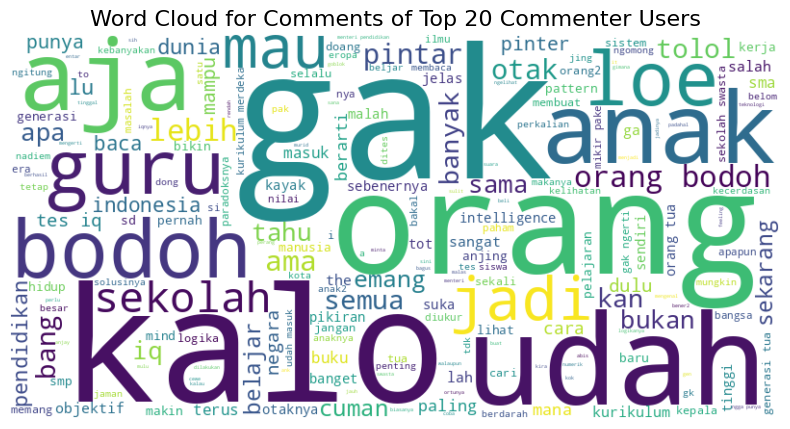

In [30]:
# Get data from the top 20 commenters and make a word cloud based on their comments

#!pip install sastrawi
from wordcloud import WordCloud
#from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import matplotlib.pyplot as plt

# Initialize the stop word remover factory
factory = StopWordRemoverFactory()
stopwords_sastrawi = set(factory.get_stop_words())  # Get the Indonesian stopwords

# Optionally, add custom stopwords
custom_stopwords = stopwords_sastrawi.union({"gw", "yg", ""})

# Get the top 20 users (or top 10, as needed)
top_20_users = sorted_users.head(20)

# Concatenate all comments for these top 20 users into one string
all_comments = ""
for _, count in top_20_users.iterrows():
    # Get all comments for each user
    user_comments = df_comments[df_comments['author'] == count['author']]['comment_text']
    # Append all comments for the user to the all_comments string
    all_comments += " ".join(user_comments) + " "

# Generate the word cloud with custom stopwords
wordcloud = WordCloud(
    stopwords=custom_stopwords,  # Add the Indonesian stopwords
    width=800,
    height=400,
    background_color='white'
).generate(all_comments)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title("Word Cloud for Comments of Top 20 Commenter Users", fontsize=16)
plt.show()


How about the first best commenter?

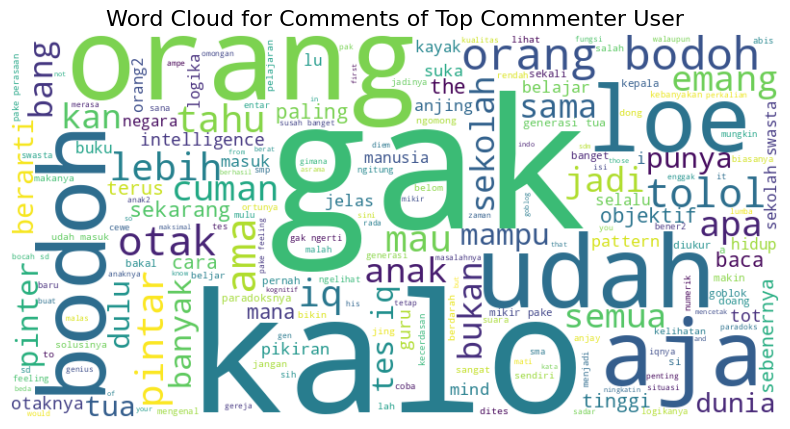

In [32]:
# Get the top user data
top_user = sorted_users.head(1)

all_comments = ""
for _, count in top_user.iterrows():
    # Get all comments for each user
    user_comments = df_comments[df_comments['author'] == count['author']]['comment_text']
    # Append all comments for the user to the all_comments string
    all_comments += " ".join(user_comments) + " "

# Generate the word cloud with custom stopwords
wordcloud = WordCloud(
    stopwords=custom_stopwords,  # Add the Indonesian stopwords
    width=800,
    height=400,
    background_color='white'
).generate(all_comments)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title("Word Cloud for Comments of Top Comnmenter User", fontsize=16)
plt.show()



Based on the two word clouds above, it can be confirmed that the most data was obtained from a single user with the most comments, whose account name is @LLLLlll__0000.

In my personal opinion, users who comment repeatedly on this content:

* Tend to blame anyone with their narrow, subjective thinking.
* Are very quick to use offensive language (toxic).
* It can be assumed that most of them blame teachers and schools for the stupidity displayed by students nowadays.

How about the wordcloud for all the comment?

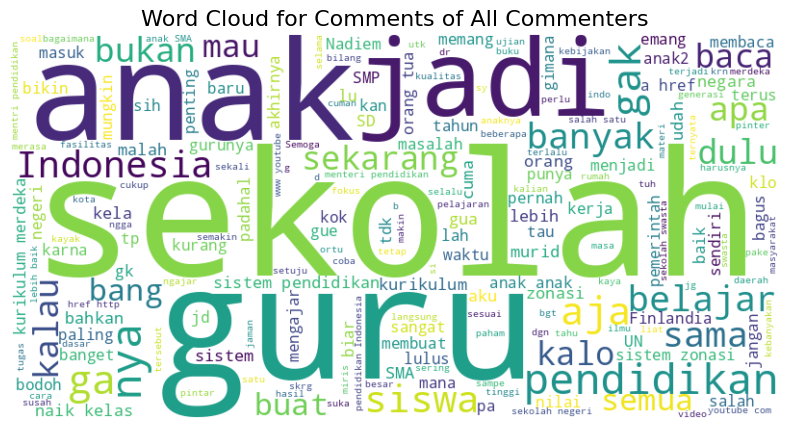

In [19]:
custom_stopwords = stopwords_sastrawi.union({"gw", "yg", "br", "quot", ""})
all_comments = ""
for _, count in sorted_users.iterrows():
    # Get all comments for each user
    user_comments = df_comments[df_comments['author'] == count['author']]['comment_text']
    # Append all comments for the user to the all_comments string
    all_comments += " ".join(user_comments) + " "

# Step 3: Generate the word cloud with custom stopwords
wordcloud = WordCloud(
    stopwords=custom_stopwords,  # Add the Indonesian stopwords
    width=800,
    height=400,
    background_color='white'
).generate(all_comments)

# Step 4: Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title("Word Cloud for Comments of All Commenters", fontsize=16)
plt.show()

# **Sentiment Analysis**

Here I want to perform sentiment analysis using a pre-trained model for Indonesian, and the model that I'll be using is IndoBERT

In [24]:
# Install the pre-requisite libraries
!pip install transformers torch

# Import the transformer
from transformers import AutoTokenizer, pipeline
import torch

# Check the structure of the DataFrame that will be using
print(df_comments.head())


                      author  \
0              @ferryirwandi   
1       @kresnadwipajana6992   
2            @jendralmartabk   
3          @MariaLudiana-y7j   
4  @adindadiansriartanti7401   

                                        comment_text          published_at  \
0       hallo warga sipil sekalian, selamat menonton  2024-10-10T09:02:59Z   
1  Jangan lupa, jika observasi ini dilakukan dala...  2024-12-02T00:11:20Z   
2  Tahun ini baru naik sma, dan ada sma favorit b...  2024-12-01T23:30:32Z   
3  Saya melihat kurikulum  k13 dan merdeka banyak...  2024-12-01T23:06:58Z   
4                                   Bener bgt bang 😔  2024-12-01T22:20:55Z   

   like_count  reply_count  
0        4257          337  
1           0            0  
2           0            0  
3           0            0  
4           0            0  


In [33]:
# Ensure GPU is available and set device
device = 0 if torch.cuda.is_available() else -1

# Check the device being used
print(f"Pipeline is using device: {'GPU' if device == 0 else 'CPU'}")


Pipeline is using device: GPU


In [38]:
# Create new dataframe for comment_text data
comments = df_comments['comment_text'].tolist()
comments

['hallo warga sipil sekalian selamat menonton',
 'jangan lupa observasi dilakukan waktu 5 tahurn terakhir harap dipertimbangkan dampak covid19 proses hasil pendidikan pasa semua jenjang sejak tahun 2020 jadi kalau pendidikan buruk rentang 5 tahun terakhir sebagian kontribusi covid19 butuh waktu 1216 tahun menunggu dampak covid19 betulbetul hilang dunia pendidikan anakanak terlihat kapabel dugaan korban pendidikan mutu prosesnya asalasalan covid19 zonasi berkontribusi bahkan berdampak kepercayaan masyarakat sekolah banyak sekolah semula bagus kemudian turun reputasinya garagara inputnya terseleksi akademik kedekatan tempat tinggal menjadi utama dipertimbangkan penerimaan peserta didik kalau alasannya pemerataan kualitas pendidikan ukuran dipakai buat menilai variabelvariabel berdimensi waktu panjang pemerataan kualitas luaran mestinya didahului pemerataan kualitas input berupa fasilitas sekolah kualitas guru jangan berharap kualitas lulusan merata kalau didahului pemerataan fasilitas ku

In [39]:
# Now let's start the pipelining

# Load the pre-trained sentiment-analysis model and its tonekizer
model_name = "indolem/indobert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the sentiment analysis pipeline with truncation and padding
sentiment_analysis = pipeline(
    "sentiment-analysis",
    model=model_name,
    tokenizer=tokenizer,
    truncation=True,
    padding='max_length',
    device=device,
    batch_size=32,
    max_length=512
)


# Function to analyze sentiment for a batch of comments
def analyze_sentiment_batch(comments_batch):
    # Process the batch of comments in one call
    results = sentiment_analysis(comments_batch)
    return results

# Process the dataset in batches
batch_size = 32
all_results = []

# Process the comments in batches
for i in range(0, len(comments), batch_size):
    batch = comments[i:i + batch_size]
    batch_results = analyze_sentiment_batch(batch)
    all_results.extend(batch_results)

# Add the results to the DataFrame
df_comments['sentiment'] = [result['label'] for result in all_results]
df_comments['score'] = [result['score'] for result in all_results]

# Show the updated DataFrame with sentiment analysis results
print(df_comments)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                           author  \
0                   @ferryirwandi   
1            @kresnadwipajana6992   
2                 @jendralmartabk   
3               @MariaLudiana-y7j   
4       @adindadiansriartanti7401   
...                           ...   
11626           @hirumayoichi2625   
11627                @Pardede-x3u   
11628  @nabilsihabbudinachmad9203   
11629               @ferryirwandi   
11630                    @KEBA613   

                                            comment_text  \
0            hallo warga sipil sekalian selamat menonton   
1      jangan lupa observasi dilakukan waktu 5 tahurn...   
2      tahun baru naik sma sma favorit banget ditempa...   
3      melihat kurikulum k13 merdeka banyak siswa bac...   
4                                         bener bgt bang   
...                                                  ...   
11626                                      28 detik lalu   
11627                                        thanks bang   
11628          

In [41]:
df_comments['sentiment'].value_counts()

,count
sentiment,
LABEL_1,7821
LABEL_0,3810


In [46]:
# Create separate df for each labels

# Identify unique labels
unique_labels = df_comments['sentiment'].unique()

# Split the DataFrame and assign to new variables
df_label_0 = df_comments[df_comments['sentiment'] == "LABEL_0"]
df_label_1 = df_comments[df_comments['sentiment'] == "LABEL_1"]

# rint the new DataFrames
print("DataFrame for label 0:\n", df_label_0, "\n")
print("DataFrame for label 1:\n", df_label_1, "\n")

DataFrame for label 0:
                   author                                       comment_text  \
2        @jendralmartabk  tahun baru naik sma sma favorit banget ditempa...   
5        @finaruzika9632           terima kasih mewakili keresahanku selama   
12             @rayfennt  makin kesini sekolah makin berbelit belit sisw...   
14       @raafisatria279                  a href benar bgpernah dengar guru   
19      @haryonoyono2076  nadim bukan ngajak anak indonesia pinter malah...   
...                  ...                                                ...   
11615    @loremipsumamet  quotguru pahlawan tanda jasaquotbr alias bener...   
11618  @IwanTaufik-jj3ox  nan diateh tu pakak tibo nan dibawah tu tambah...   
11619          @bdgsh490                          kabar frog bagaimana bang   
11621      @diazazhar945  bukan komen bermutu akhirnya komen cuma bebera...   
11627       @Pardede-x3u                                        thanks bang   

               published_at

For a clearer view, let's create new df for specified columns only

In [54]:
SA_result_all = df_comments[['comment_text', 'sentiment', 'score']]
display(SA_result_all.head(5))
display(SA_result_all['sentiment'].value_counts())

,comment_text,sentiment,score
0,hallo warga sipil sekalian selamat menonton,LABEL_1,0.526465
1,jangan lupa observasi dilakukan waktu 5 tahurn...,LABEL_1,0.561604
2,tahun baru naik sma sma favorit banget ditempa...,LABEL_0,0.501195
3,melihat kurikulum k13 merdeka banyak siswa bac...,LABEL_1,0.605007
4,bener bgt bang,LABEL_1,0.603343


,count
sentiment,
LABEL_1,7821
LABEL_0,3810


In [48]:
SA_result_0 = df_label_0[['comment_text', 'sentiment', 'score']]
SA_result_0.head(5)

,comment_text,sentiment,score
2,tahun baru naik sma sma favorit banget ditempa...,LABEL_0,0.501195
5,terima kasih mewakili keresahanku selama,LABEL_0,0.603328
12,makin kesini sekolah makin berbelit belit sisw...,LABEL_0,0.556761
14,a href benar bgpernah dengar guru,LABEL_0,0.583407
19,nadim bukan ngajak anak indonesia pinter malah...,LABEL_0,0.521270


In [49]:
SA_result_1 = df_label_1[['comment_text', 'sentiment', 'score']]
SA_result_1.head(5)

,comment_text,sentiment,score
0,hallo warga sipil sekalian selamat menonton,LABEL_1,0.526465
1,jangan lupa observasi dilakukan waktu 5 tahurn...,LABEL_1,0.561604
3,melihat kurikulum k13 merdeka banyak siswa bac...,LABEL_1,0.605007
4,bener bgt bang,LABEL_1,0.603343
6,harusnya mengadopsi sistem korsel cina butuh d...,LABEL_1,0.688277


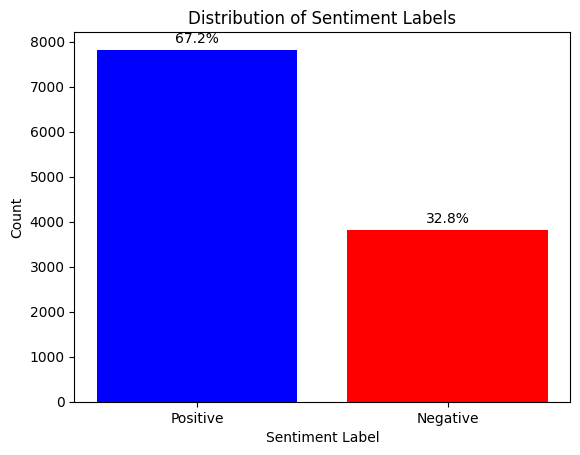

In [55]:
# Visualize the sentiment labels

# Calculate the counts and percentages for each label
label_counts = SA_result_all['sentiment'].value_counts()
label_percentages = label_counts / label_counts.sum() * 100

# Create the bar plot
fig, ax = plt.subplots()
bars = ax.bar(label_counts.index, label_counts, color=['blue', 'red'])

# Add percentage labels to the bars
for bar, percentage in zip(bars, label_percentages):
    height = bar.get_height()
    ax.annotate(f'{percentage:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Add a label at the top of the bar
if 1 in label_counts.index:
    positive_bar = bars[1] if label_counts.index[0] == 0 else bars[0]
    height = positive_bar.get_height()
    ax.annotate('Positive',
                xy=(positive_bar.get_x() + positive_bar.get_width() / 2, height),
                xytext=(0, 15),  # 15 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                color='white', fontsize=12, fontweight='bold')

# Set labels and title
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Count')
ax.set_title('Distribution of Sentiment Labels')
ax.set_xticks(label_counts.index)
ax.set_xticklabels(['Positive', 'Negative'])

# Step 8: Show the plot
plt.show()


Based on the bar plot above, it can be seen that positive sentiment is more prevalent than negative sentiment, with a ratio almost approaching 7:3. <br>


However, it is still important to understand the context, whether the positive sentiment is caused by the commentator's agreement with the content, or their approval of the implementation of education in the style of developed countries. <br>

Let's take a look at the word cloud for each label.

In [62]:
!pip install sastrawi

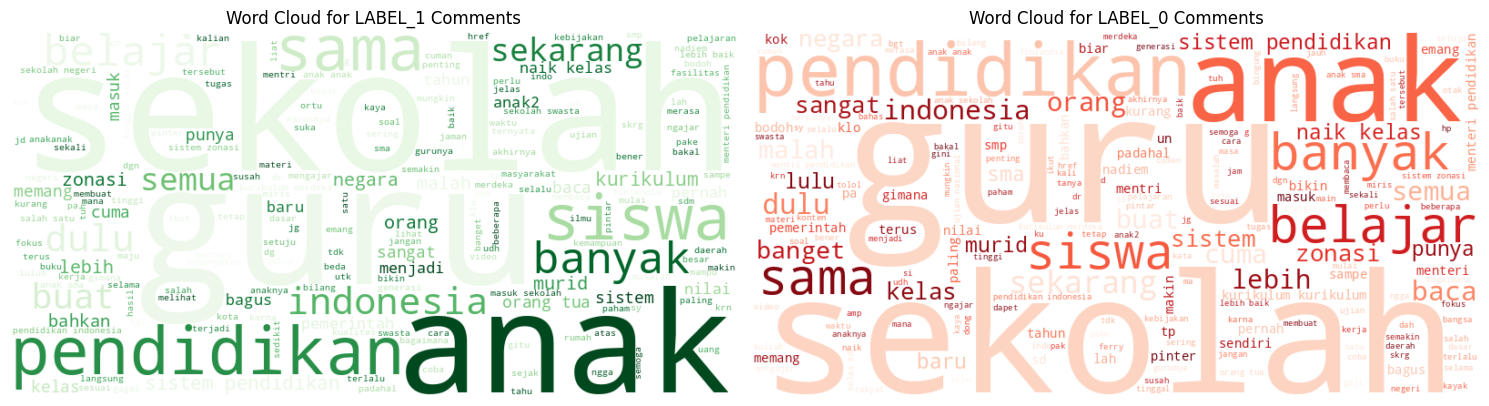

In [78]:
#!pip install sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# List of unique sentiment labels
sentiment_labels = df_comments['sentiment'].unique()

# Initialize the stop word remover factory
factory = StopWordRemoverFactory()
stopwords_sastrawi = set(factory.get_stop_words())  # Get the Indonesian stopwords

# Create a custom list of stopwords
custom_stopwords = set([
    'gw', 'gue', 'saya', 'aku', 'lu', 'ga', 'yg', 'nya', 'jadi', 'aja', 'gak', 'kalo', 'mau',
    'bang', 'bukan', 'kalau', 'apa', 'tau', 'gua', 'sih', 'udah', 'kela', 'gk', 'kan'
])

# Combine Sastrawi stopwords with custom stopwords
combined_stopwords = stopwords_sastrawi.union(custom_stopwords)

# Create a word cloud for each sentiment label
plt.figure(figsize=(15, 10))

for i, label in enumerate(sentiment_labels):
    # Filter comments for the current sentiment label
    comments_text = ' '.join(df_comments[df_comments['sentiment'] == label]['comment_text'].tolist())

    # Remove stopwords using Sastrawi and custom stopwords
    filtered_comments = ' '.join([word for word in comments_text.split() if word.lower() not in combined_stopwords])

    # Set color map based on the sentiment label
    if label == 'LABEL_1':
        colormap = 'Greens'  # Green shades for label 1
    else:
        colormap = 'Reds'  # Red shades for label 0

    # Generate the word cloud
    wordcloud = WordCloud(
        width=800, height=400, background_color='white', colormap=colormap
    ).generate(filtered_comments)

    # Plot the word cloud
    plt.subplot(1, len(sentiment_labels), i+1)  # Adjust the number of columns dynamically
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label} Comments')

# Display the word clouds
plt.tight_layout()
plt.show()

# **Conclusion**
Based on the word clouds above, the conclusions that can be drawn are as follows (author subjective):

1. The data is of a general sentiment nature, meaning that there is no clear agreement or disagreement between positive and negative sentiments.
2. The data with positive sentiment can be assumed to be critical and structured comments, without using bad or toxic language, and generally not blaming.
3. In the word cloud for negative sentiment, the terms "Minister of Education" and "education system" appear, indicating that comments with negative sentiment tend to blame the Minister of Education and the education system for what has happened.
4. The words school, teacher, children, and education appear most frequently across all comments, indicating that almost all comments on the YouTuber Ferry Irwandi's content are relevant to the content itself.